In [2]:
import numpy as np
import pandas as pd
import os
import argparse
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import gc
from keras.models import Sequential, Model
from keras.layers import Input,Embedding,LSTM,Dense
from keras.optimizers import Adam
from keras.layers import Input, concatenate, Embedding, Reshape
from keras.layers import Merge, Flatten, merge, Lambda, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2, l1_l2

/Users/BharathiSrinivasan/anaconda2/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Input datasets
myfolder = '/Users/BharathiSrinivasan/Documents/HU-MEMS-Sem3/Info_Systems/repo/Recommender_DNN/Data/'
big_users = pd.read_csv(myfolder + 'bigtrain35.csv')
big_users.head(n=5)

,user_id,user_orders,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,17,40,1737705,0,1,2,13,30,7350,1,0,115,7
1,17,40,1681401,0,2,5,10,3,7350,1,1,115,7
2,17,40,2680214,0,3,3,10,5,7350,1,1,115,7
3,17,40,3237467,0,5,6,17,5,7350,1,1,115,7
4,17,40,2616505,0,6,4,17,5,7350,2,1,115,7


# Feature Engineering

In [ ]:
print('Creating features I ...')

# sort orders and products to get the rank or the reorder frequency
prdss = big_users.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prdss['product_time'] = prdss.groupby(['user_id', 'product_id']).cumcount()+1

# getting products ordered first and second times to calculate probability later
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

del sub1, sub2, prdss
gc.collect()

print('Creating features II ...')

# extracting prior information (features) by user
users = big_users.groupby(['user_id'])['order_number'].max().to_frame('user_orders')
users['user_period'] = big_users.groupby(['user_id'])['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = big_users.groupby(['user_id'])['days_since_prior_order'].mean()

# merging features about users and orders into one dataset
us = big_users.groupby('user_id').size().to_frame('user_total_products')
us['eq_1'] = big_users[big_users['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = big_users[big_users['order_number'] > 1].groupby('user_id')['product_id'].size()
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
us['user_distinct_products'] = big_users.groupby(['user_id'])['product_id'].nunique()

# the average basket size of the user
users = users.reset_index().merge(us.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

us = big_users
us = us[['user_id', 'order_id', 'days_since_prior_order']]
users = users.merge(us)

del us
gc.collect()

print('Finalizing features and the main data file  ...')
# merging orders and products and grouping by user and product and calculating features for the user/product combination
data = big_users.groupby(['user_id', 'product_id']).size().to_frame('up_orders')
data['up_first_order'] = big_users.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = big_users.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = big_users.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

#merging previous data with users
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

#user/product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['user_orders']
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']
df = data.merge(big_users[['user_id', 'product_id', 'reordered']],
                  how = 'left', on = ['user_id', 'product_id'])

Creating features I ...
Creating features II ...
Finalizing features and the main data file  ...


In [ ]:
df.drop(['eval_set'],axis=1)
y = df['reordered'].values
df.pop('reordered')

# Model Selection

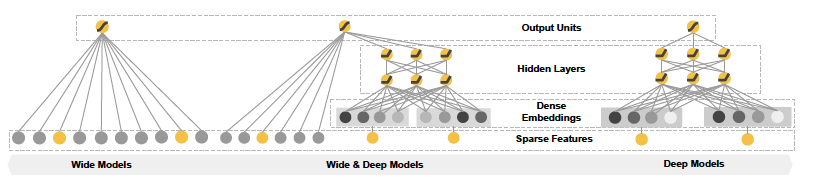

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/Users/BharathiSrinivasan/Documents/"
Image(filename = PATH + "wide_deep.png", width=1200, height=1500)

# Feature Vectors

In [ ]:
CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day"]
CONTINUOUS_COLUMNS = [ "user_orders", "order_number", "add_to_cart_order","days_since_prior_order","up_orders","up_first_order","up_last_order","up_average_cart_position","prod_orders","prod_reorder_probability","prod_reorder_ratio","user_orders","user_distinct_products","user_average_basket","up_order_rate"]
EMBEDDING_COLUMNS = ["user_id", "product_id","order_id","aisle_id","department_id"]

In [ ]:
#Normalising the feature columns
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [ ]:
#One-hot encoding categorical columns
df = pd.get_dummies(df, columns=[x for x in CATEGORICAL_COLUMNS])

In [ ]:
#Helper to index columns before embeddings
def val2idx(df, cols):
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals

In [ ]:
#Using Keras layer to create Embeddings for deep network
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [ ]:
#Input layers for continuous vectors to the deep network
def continous_input(name):
    inp = Input(shape=(1,), dtype='float32', name=name)
    return inp, Reshape((1, 1))(inp)

In [ ]:
#Splitting datasets into train and test
df.reset_index()
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Linear Estimator
## Memorization : 
    -learning frequent co-occurence of features
    -exploiting correlation available in the historical data
    -more topical and directly relevant to items on which users have performed some action
    
## Why are linear models widely used?
    -simple, scalable, interpretable

## Form of the model:
    y = W^{T}x + b
    

In [ ]:
# simply connecting the features to an output layer
wide_inp = Input(shape=(X_train.shape[1],), dtype='float32', name='wide_inp')
wide_out = Dense(1, activation='sigmoid')(wide_inp)
wide = Model(wide_inp, wide_out)
wide.compile(Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
wide.fit(X_train, y_train, nb_epoch=1,batch_size =64)
results = wide.evaluate(X_test, y_test)

print("\n", results)

In [ ]:
# serialize linear model to JSON
wide_json = wide.to_json()
with open("wide.json", "w") as json_file:
    json_file.write(wide_json)
# serialize weights to HDF5
model.save_weights("wide.h5")
print("Saved model to disk")

# Deep Neural Network
## Generalization
    -based on transitivity of correlation
    -explores new feature combinations that have rarely/neevr occured in the past
## Why do we use it?
    -Tends to improve the diversity of recommended items
    -Embeddings can geenralize to previously unseen user-item feature  pairs by learning low dimensional, dense  vectors

In [ ]:
df_deep, unique_vals = val2idx(df, EMBEDDING_COLUMNS)
X_deep_tr, X_deep_te, y_deep_tr, y_deep_te = train_test_split(df_deep, y, test_size=0.25, random_state=42)

In [ ]:
#Defining input column for the deep network
DEEP_COLNS = EMBEDDING_COLUMNS + CONTINUOUS_COLUMNS

In [ ]:
#Creating input dataframe for the merged model
X_train_deep = [X_deep_tr[c] for c in DEEP_COLNS]
y_train_deep = np.array(y_deep_tr).reshape(-1, 1)
X_test_deep = [X_deep_te[c] for c in DEEP_COLNS]
y_test_deep = np.array(y_deep_te).reshape(-1, 1)

In [ ]:
#Building input tensors for deep network
embeddings_tensors = []
n_factors = 8
reg = 1e-3

for ec in EMBEDDING_COLUMNS:
    layer_name = ec + '_inp'
    t_inp, t_build = embedding_input(
    layer_name, unique_vals[ec], n_factors, reg)
    embeddings_tensors.append((t_inp, t_build))
    del(t_inp, t_build)
    
continuous_tensors = []
for cc in CONTINUOUS_COLUMNS:
    layer_name = cc + '_in'
    t_inp, t_build = continous_input(layer_name)
    continuous_tensors.append((t_inp, t_build))
    del(t_inp, t_build)

In [ ]:
#Building inputs for deep network
deep_inp_layer =  [et[0] for et in embeddings_tensors]
deep_inp_layer += [ct[0] for ct in continuous_tensors]
deep_inp_embed =  [et[1] for et in embeddings_tensors]
deep_inp_embed += [ct[1] for ct in continuous_tensors]

In [ ]:
#Modeling deep network

d = merge(deep_inp_embed, mode='concat')
d = Flatten()(d)
# 2_. layer to normalise continous columns with the embeddings
d = BatchNormalization()(d)
d = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(d)
d = Dense(50, activation='relu')(d)

deep_out = Dense(y_train_deep.shape[1], activation='sigmoid')(d)
deep = Model(deep_inp_layer, deep_out)
deep.compile(Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])
deep.fit(X_train_deep, y_train_deep, batch_size=64, nb_epoch=1)
results = deep.evaluate(X_test_deep, y_test_deep)

print ("\n", results)

In [ ]:
# serialize deep model to JSON
deep_json = deep.to_json()
with open("deep.json", "w") as json_file:
    json_file.write(deep_json)
# serialize weights to HDF5
model.save_weights("deep.h5")
print("Saved model to disk")

# Wide + Deep Combined Model
## Joint Training of wide and deep 
    - combined using a weighted sum of output predictions
    -fed to a  common logistic loss function for joint training
## Model's Prediction:
     P(Y=1|x) = f( W^{T}_{wide}[x] + W^{T}_{deep}a^{(l)} + b )

In [ ]:
#Inputs
X_tr_wd = [X_train] + X_train_deep
Y_tr_wd = y_train_deep  # wide or deep is the same here
X_te_wd = [X_test] + X_test_deep
Y_te_wd = y_test_deep  # wide or deep is the same here

In [ ]:
# WIDE
w = Input(shape=(X_train.shape[1],), dtype='float32', name='wide')

# WIDE + DEEP
wd_inp = concatenate([w, d])
wd_out = Dense(Y_tr_wd.shape[1], activation='sigmoid', name='wide_deep')(wd_inp)

wide_deep = Model(inputs=[w] + deep_inp_layer, outputs=wd_out)

wide_deep.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
wide_deep.fit(X_tr_wd, Y_tr_wd, nb_epoch=1, batch_size=128)

results = wide_deep.evaluate(X_te_wd, Y_te_wd)

print( "\n", results)

In [ ]:
# serialize model to JSON
wide_deep_json = wide_deep.to_json()
with open("wide_deep.json", "w") as json_file:
    json_file.write(wide_deep_json)
# serialize weights to HDF5
model.save_weights("wide_deep.h5")
print("Saved model to disk")

# Results and Evaluation

In [ ]:
#Loading pre-trained models

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
